## Train probe
- Goal: To train MVP probes on activations
    - Maybe make those probes be fancy (mean, attention, softmax)
    - Maybe make those activations be real

### Get activations (currently unused)

In [1]:
device = "cpu"
# device = "cuda"

In [ ]:
import torch
from transformer_lens import HookedTransformer

# from huggingface_hub import login
# login(token="token_here")

## Small models
# model_name = "tiny-stories-1M"
# model_name = "tiny-stories-3M"
# model_name = "tiny-stories-8M"
# model_name = "tiny-stories-28M"
# model_name = "tiny-stories-33M"
# model_name = "tiny-stories-instruct-33M"

## Large models
model_name = "gpt2-small"
# model_name = "gpt2-medium"
# model_name = "gpt2-xl"
# model_name = "llama-7b"
# model_name = "meta-llama/Llama-3.2-1B"
# model_name = "meta-llama/Llama-3.2-1B-Instruct"
# model_name = "Qwen/Qwen2.5-0.5B"
# model_name = "Qwen/Qwen2.5-1.5B"
# model_name = "Qwen/Qwen2.5-3B"

model = HookedTransformer.from_pretrained(model_name, device=device)
model = model.eval()

Loaded pretrained model gpt2-small into HookedTransformer


In [ ]:
# Can get logits and activations for one forward pass
test_string = """Mini scule is a species of microhylid frog endemic to Madagascar that was described in 2019. The scientific name of the"""
test_tokens = model.to_tokens(test_string)#.cuda()
print(test_tokens.shape)

logits, cache = model.run_with_cache(test_tokens, remove_batch_dim=True)
print(logits.shape)
print(cache)

torch.Size([1, 27])
torch.Size([1, 27, 50257])
ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out'

In [ ]:
# # Can also autoregressively generate from <path_start> onwards
# test_string = """Mini scule is a species of microhylid frog endemic to Madagascar that was described in 2019. The scientific name of the"""
# test_tokens = model.to_tokens(test_string)#.cuda()
# print(test_tokens.shape)

# predictions = model.generate(
#     test_tokens,
#     max_new_tokens=20,
#     do_sample=True,
#     verbose=False,
#     return_type="tokens",)
# print(model.tokenizer.decode(predictions[0]))

torch.Size([1, 27])
<|endoftext|>Mini scule is a species of microhylid frog endemic to Madagascar that was described in 2019. The scientific name of the species is stratagalidal sculeata.

Locations Honeylatrina 1849,


In [ ]:
# Generate random input using model vocab
test_tokens1 = torch.randint(0, len(model.tokenizer.vocab), (1, 10), device=device)
_, cache1 = model.run_with_cache(test_tokens1, remove_batch_dim=True)

test_tokens2 = torch.randint(0, len(model.tokenizer.vocab), (1, 10), device=device)
_, cache2 = model.run_with_cache(test_tokens2, remove_batch_dim=True)


### Do probe training

Training linear probe...
Train data: torch.Size([1000, 10, 256]), Val data: torch.Size([10, 10, 256])
Epoch 1/100, Train Loss: 1.5220, Val Loss: 0.6025
Epoch 2/100, Train Loss: 1.0104, Val Loss: 0.3673
Epoch 3/100, Train Loss: 0.9188, Val Loss: 0.2370
Epoch 4/100, Train Loss: 0.8591, Val Loss: 0.1828
Epoch 5/100, Train Loss: 0.8107, Val Loss: 0.1490
Epoch 6/100, Train Loss: 0.7602, Val Loss: 0.1296
Epoch 7/100, Train Loss: 0.7146, Val Loss: 0.1176
Epoch 8/100, Train Loss: 0.6743, Val Loss: 0.0989
Epoch 9/100, Train Loss: 0.6299, Val Loss: 0.0876
Epoch 10/100, Train Loss: 0.5875, Val Loss: 0.0803
Epoch 11/100, Train Loss: 0.5519, Val Loss: 0.0715
Epoch 12/100, Train Loss: 0.5211, Val Loss: 0.0641
Epoch 13/100, Train Loss: 0.4894, Val Loss: 0.0618
Epoch 14/100, Train Loss: 0.4637, Val Loss: 0.0571
Epoch 15/100, Train Loss: 0.4384, Val Loss: 0.0531
Epoch 16/100, Train Loss: 0.4173, Val Loss: 0.0501
Epoch 17/100, Train Loss: 0.3992, Val Loss: 0.0501
Epoch 18/100, Train Loss: 0.3816, Val Lo

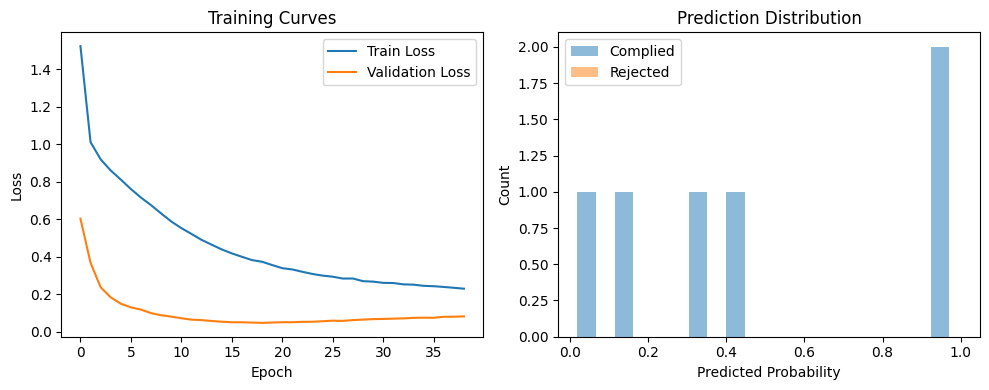

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from probe_gen.probe_train import train_probe, evaluate_probe


# Generate synthetic activation data
np.random.seed(42)
torch.manual_seed(42)

# Simulate activations: (batch_size, seq_len, hidden_dim)
n_train, n_val, n_test = 1000, 10, 10
seq_len = 10
hidden_dim = 256

# Create synthetic data where rejected samples have higher mean activation
def create_synthetic_data(n_samples):
    activations = torch.randn(n_samples, seq_len, hidden_dim)
    labels = torch.randint(0, 2, (n_samples,))
    
    # Make rejected samples (label=1) have slightly higher activations in some dimensions
    rejected_mask = labels == 1
    activations[rejected_mask, :, :100] += 0.5  # Boost first 100 dimensions
    
    return activations, labels.float()

train_activations, train_labels = create_synthetic_data(n_train)
val_activations, val_labels = create_synthetic_data(n_val)
test_activations, test_labels = create_synthetic_data(n_test)

print("Training linear probe...")
print(f"Train data: {train_activations.shape}, Val data: {val_activations.shape}")

# Train probe
model, train_losses, val_losses = train_probe(
    train_activations=train_activations,
    train_labels=train_labels,
    val_activations=val_activations,
    val_labels=val_labels,
    probe_type="mean",
    learning_rate=5e-3,
    batch_size=16,
    num_epochs=100,
    early_stop_patience=20
)

# Evaluate probe
print("\nEvaluating probe...")
results = evaluate_probe(model, test_activations, test_labels)

print(f"Test Accuracy: {results['accuracy']:.4f}")
print(f"Test AUC-ROC: {results['auc_roc']:.4f}")
print(f"TPR at 1% FPR: {results['tpr_at_1_fpr']:.4f}")

# Plot training curves
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Curves')

plt.subplot(1, 2, 2)
plt.hist(results['probabilities'][test_labels.numpy() == 0], alpha=0.5, label='Complied', bins=20)
plt.hist(results['probabilities'][test_labels.numpy() == 1], alpha=0.5, label='Rejected', bins=20)
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.legend()
plt.title('Prediction Distribution')

plt.tight_layout()
plt.show()